In [1]:
import pandas as pd
import numpy as np
from ggplot import *
from scipy.stats import ttest_ind, pearsonr
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as mae
from pylab import *
from matplotlib import pyplot
import xgboost as xgb
%matplotlib inline

/home/stepan/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Загружает нашу выборку

In [2]:
data = pd.read_csv('cian.csv')

Вспомним, как выглядят наши данные

In [3]:
data.head()

,N,Okrug,Rooms,Price,Totsp,Livesp,Kitsp,Dolgota,Shirota,Dist,Metrdist,Walk,Brick,Tel,Bal,Floor,Nfloors,New,View,Elevator
0,149881502,0.0,1.0,20112000.0,50.8,30.0,10.0,37.637605,55.769519,2.080620,7.0,1.0,1.0,1.0,0.0,4.0,8.0,0.0,двор и улица,1.0
1,143084951,0.0,5.0,71990000.0,165.3,93.0,26.0,37.620016,55.770578,1.875786,5.0,1.0,1.0,0.0,1.0,5.0,9.0,0.0,двор,1.0
2,149444630,0.0,1.0,29895000.0,48.2,39.5,8.0,37.618569,55.722142,3.510959,7.0,1.0,1.0,0.0,0.0,13.0,13.0,0.0,улица,1.0
3,151071264,0.0,5.0,1730000.0,194.2,1.0,NaN,37.618569,55.722142,3.510959,9.0,1.0,0.0,0.0,1.0,10.0,13.0,0.0,двор и улица,1.0
4,149031353,0.0,1.0,4403057.0,22.7,22.7,NaN,37.671938,55.775753,4.078597,6.0,1.0,0.0,0.0,0.0,3.0,NaN,1.0,–,1.0


В Москве бывают неимоверно дорогие квартиры. Сгладим эту разницу в ценах

In [4]:
data['logPrice'] = np.log10(data['Price'])

Построим гистограмму "количества нулей" в цене квартиры

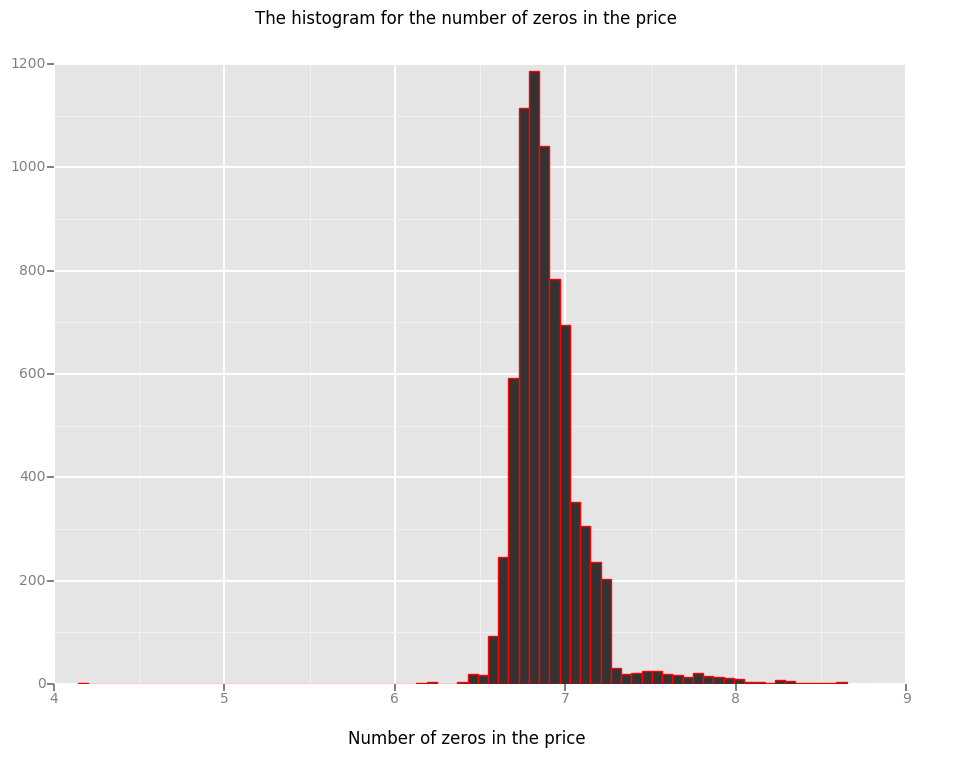

<ggplot: (-9223363263897617348)>

In [5]:
ggplot(aes(x='logPrice'),data=data)+geom_histogram(bins = 75,color='red')+\
ggtitle("The histogram for the number of zeros in the price")+\
xlab("Number of zeros in the price")

Вряд ли квартира в москве может стоить меньше миллиона. Отсеим такие квартиры

In [6]:
data = data[data['logPrice']>6]

Посмотрим на гистограмму теперь

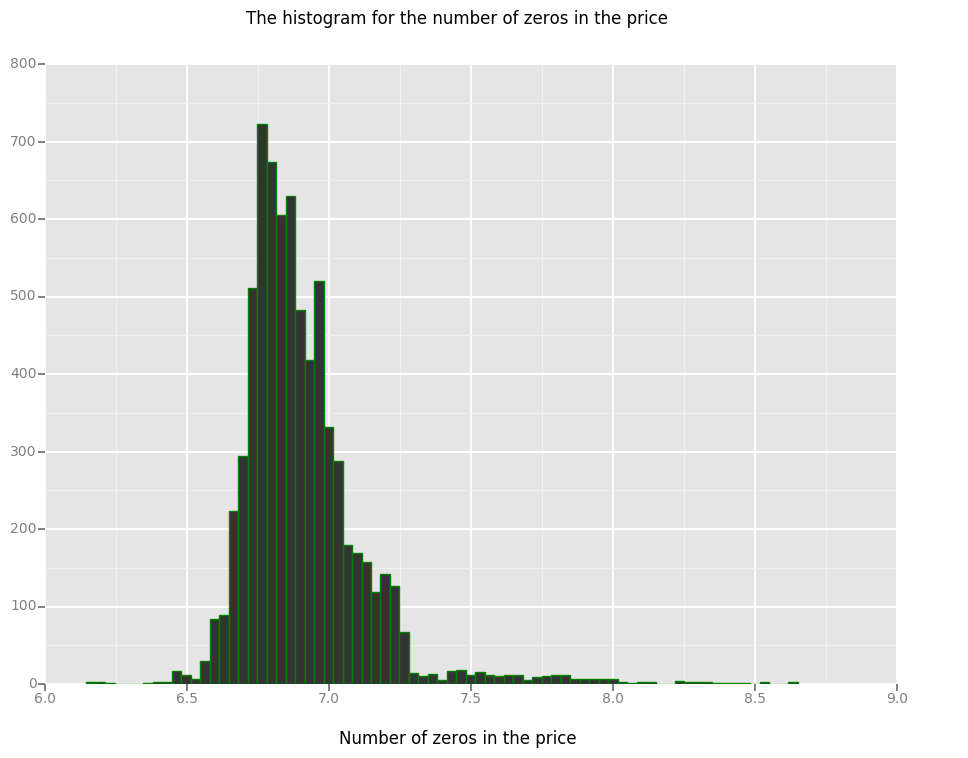

<ggplot: (-9223363263900064007)>

In [7]:
ggplot(aes(x='logPrice'),data=data)+geom_histogram(bins = 75,color='green')+\
ggtitle("The histogram for the number of zeros in the price")+\
xlab("Number of zeros in the price")

Давайте посмотрим на "тепловую карту" стоимостей квартир. Как и следовало ожидать - в центре бывают очень дорогие квартиры, так же как и на элитарном западе столицы

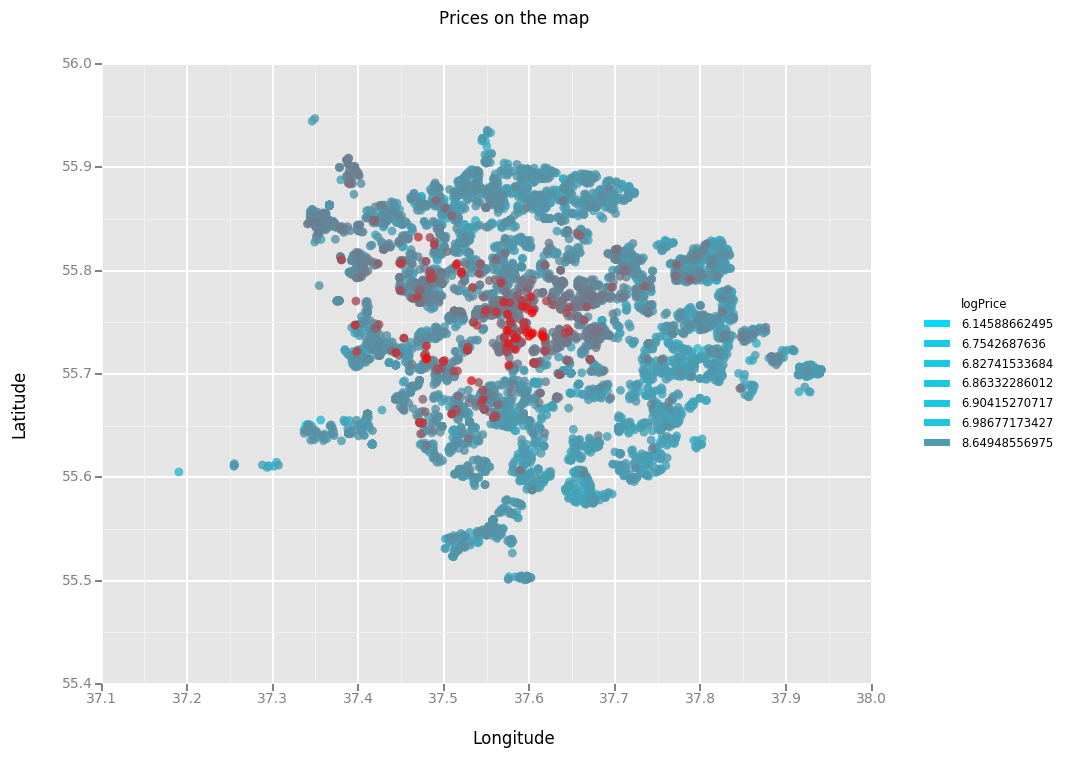

<ggplot: (8772954704346)>

In [8]:
ggplot(aes(x='Dolgota',y='Shirota',color='logPrice'),data=data.sort_values('logPrice'))+\
geom_point(size=40,alpha=0.8)+scale_color_gradient(low="#05D9F6", high="#FF0000")+\
xlab('Longitude')+ylab('Latitude')+ggtitle('Prices on the map')

При логарифмировании зависимой и объясняющей переменной в регрессии мы начианаем исследовать зависимости относительных изменений

In [9]:
data['logTotsp'] = np.log(data['Totsp'])

Посмотрим на зависимость логарифма цены квартиры от логарифма площади (и для большей информативности разметим количество комнат цветами). Хотелось бы увидеть линейную заисимость, ведь это совпадает с личным опытом: чем больше квартира - тем дороже, но чем больше - тем меньше вклад одного нового квадратного метра

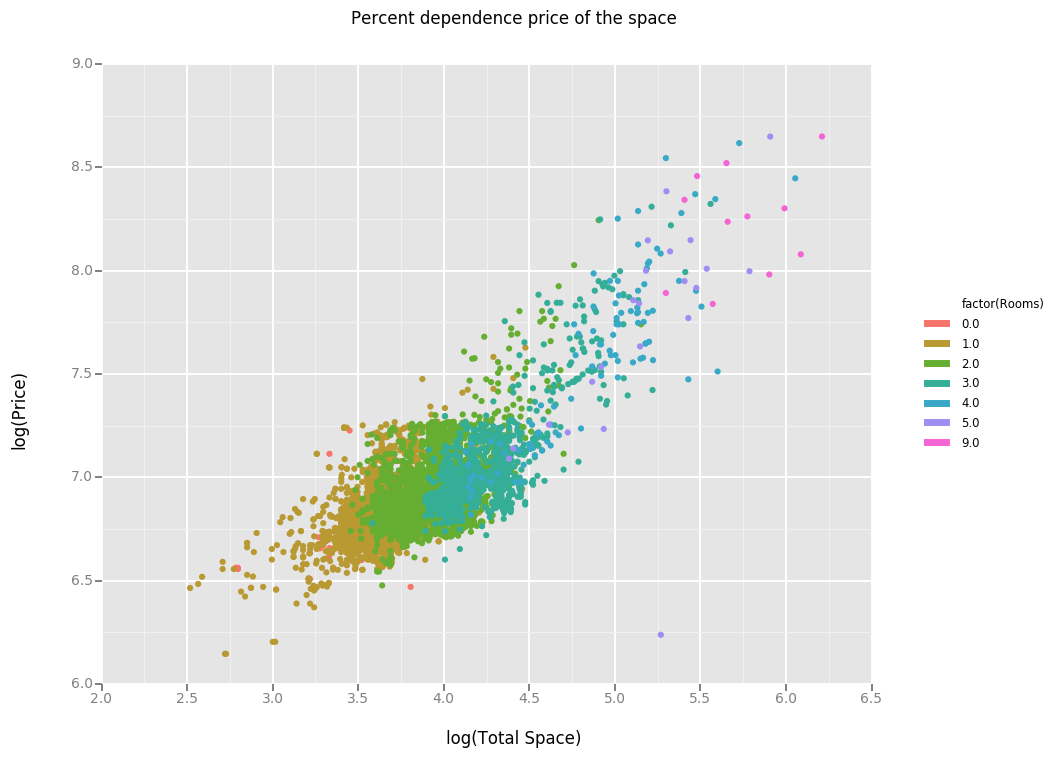

<ggplot: (8772954588764)>

In [10]:
ggplot(aes(x='logTotsp', y='logPrice',color='factor(Rooms)'), data=data) + geom_point()+\
labs(x='log(Total Space)', y='log(Price)', title='Percent dependence price of the space')

Посмотрим на плотности распределения цен в зависимости от округа. Как видно из графиков, плотности в ЦАО и ЗАО смещены вправо относительно других округов. Что совпадает с тем, что мы видели на "тепловой" карте

0 - ЦАО, 1 - САО, 2 - СВАО, 3 - ВАО, 4 - ЮВАО, 5 - ЮАО, 6 - ЮЗАО, 7 - ЗАО, 8 - СЗАО

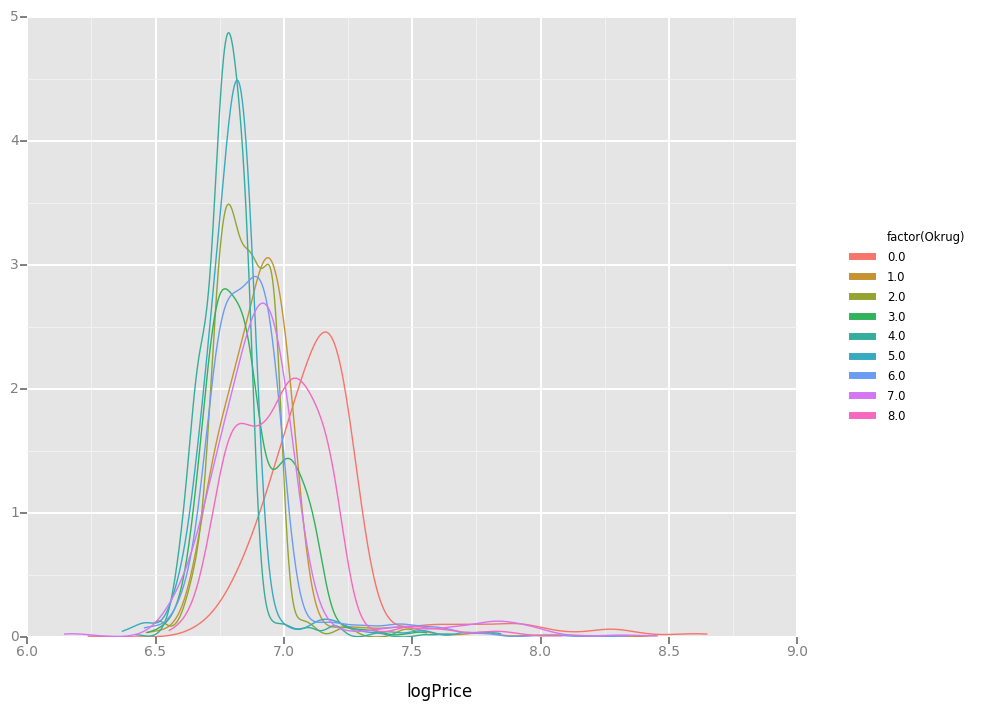

<ggplot: (-9223363263900263087)>

In [11]:
ggplot(aes(x='logPrice', color='factor(Okrug)'),data=data) +\
    geom_density()

Еще один важный график зависимостей

Put a bird on it!


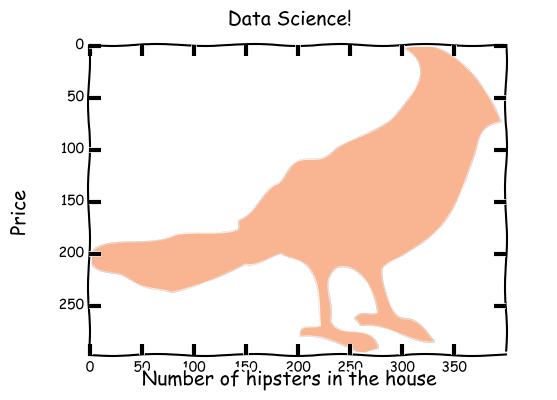

<ggplot: (-9223363282007369156)>

In [12]:
ggplot(aes('Nfloors', 'Price'),data=data) + \
    geom_now_its_art() + xlab('Number of hipsters in the house')+\
    ggtitle("Data Science!")+theme_xkcd()

Начнем подгатавливать выборку к исследованию. Сохраним и уберем из базы объясняемую переменную цены, удалим бесполезную перменную номера квартиры на сайте и переведем строковую переменную в числовую

In [13]:
y1 = data['Price']
y2 = data['logPrice']
del data['Price']
del data['logPrice']
del data['N']
data['View'] = pd.factorize(data['View'].values, sort=True)[0]

Посмотрим, где и сколько у нас пропусков

In [14]:
for i in data.columns:
    if sum(data[i].isnull())>0:
        print(i,sum(data[i].isnull()))

Livesp 726
Kitsp 1153
Metrdist 783
Nfloors 86


Надо как-то исправлять. Желательно умно. Создадим вспомогательную таблицу без пропусков

In [15]:
data2 = data[['Totsp','Livesp','Kitsp','Rooms','logTotsp']].copy()
data2 = data2.dropna().copy()

Вычислим отношения площадей

In [16]:
data2['L/T'] = data2['Livesp']/data2['Totsp']
data2['K/T'] = data2['Kitsp']/data2['Totsp']

Посмотрим, как относится площадь кухни к общей площади в зависимости от размера квартиры

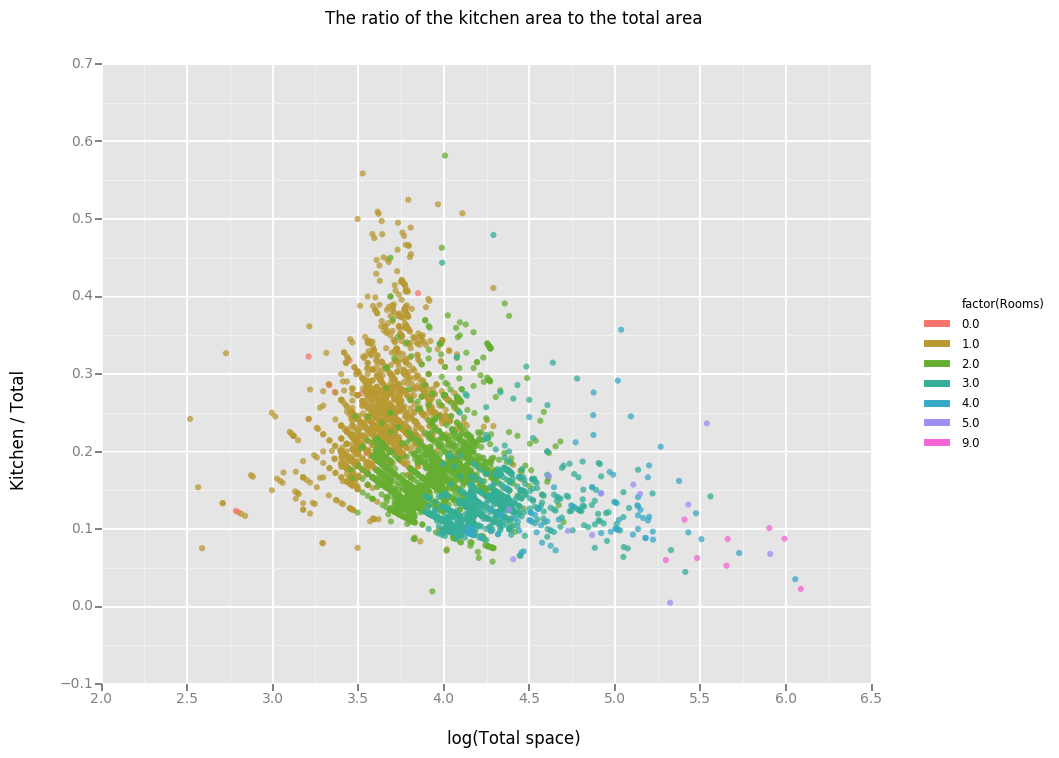

<ggplot: (8772948325440)>

In [17]:
ggplot(aes(x='logTotsp',y='K/T',color='factor(Rooms)'),data=data2)+geom_point(alpha=0.75)+\
labs(title='The ratio of the kitchen area to the total area',x='log(Total space)',y='Kitchen / Total')

Как и следовало ожидать: относительные размеры кухни падают. Ведь в больших квартирах много спален, ванных комнат, встречаются спортзалы, кабинеты и т.д., но кухня все равно одна. И больше определенного размера кухня не нужна. Вычислим средний относительный размер кухни, группируя по количеству комнат

In [18]:
KT = {}
for i in data['Rooms'].unique():
    KT.update({i:np.mean(data2['K/T'][data2['Rooms']==i])})
KT

{0.0: 0.25131031385227026,
 1.0: 0.2384862299457062,
 2.0: 0.16854123651544148,
 3.0: 0.1281665538679396,
 4.0: 0.12579351798162566,
 5.0: 0.11945338823951296,
 9.0: 0.07320842313814654}

Вспомгательная функция

In [19]:
def KTf(rooms,KT=KT):
    return KT[rooms]

Теперь мы можем заполнить пропуски в площадях кухонь. Заменим их на площадь кухни, какую следовало бы ожидать при таком количестве комнат и площади квартиры, умножим всю площадь на средние отношение при таком количестве комнат

In [20]:
data['K/T'] = data['Rooms'].apply(KTf)
data['Kitsp'][data['Kitsp'].isnull()] = data['Totsp'][data['Kitsp'].isnull()]*\
                                        data['K/T'][data['Kitsp'].isnull()]
del data['K/T']

/home/stepan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


А теперь посмотрим, как относится жилая площадь к общей площади в зависимости от размера квартиры

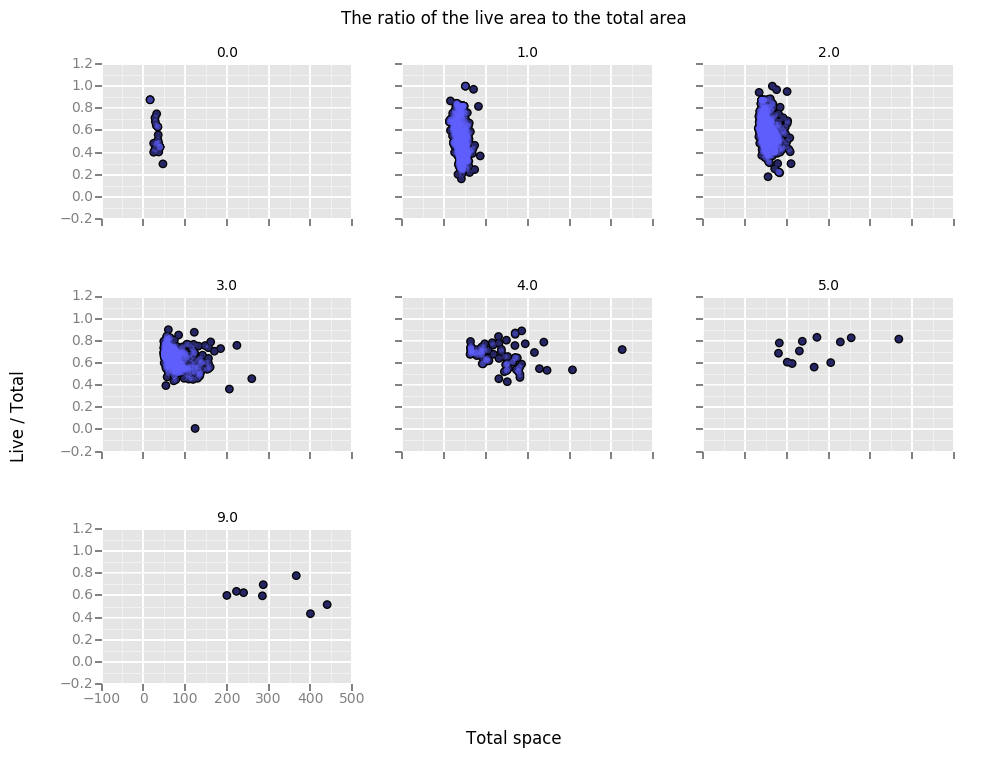

<ggplot: (-9223363263906498535)>

In [21]:
ggplot(aes(x='Totsp',y='L/T'),data=data2)+geom_point(size=40,alpha=1)+\
geom_point(color='#6060FF',size=20,alpha=0.4)+facet_wrap('Rooms')+\
labs(title='The ratio of the live area to the total area',x='Total space',y='Live / Total')

Появились подозрения, что в среднем отношение жилой площади ко всей площади одинаково при любом количестве комнат. Судя по графикам, да и просто размышляя. Ведь при увеличении общей площади суммарный размер коридоров и ванных комнат тоже растет пропорционально. А значит время для t-критерия Стьюдента о равенстве средних!

In [22]:
for i in range(len(data2['Rooms'].unique())):
    for j in range(i+1,len(data2['Rooms'].unique())):
        print(int(data2['Rooms'].unique()[i]),int(data2['Rooms'].unique()[j]),
              ttest_ind(data2['L/T'][data2['Rooms']==data2['Rooms'].unique()[i]],
                  data2['L/T'][data2['Rooms']==data2['Rooms'].unique()[j]],
                  equal_var=False,nan_policy='omit')[1])

1 5 1.86106091117e-05
1 3 3.21069025681e-304
1 4 3.03913313217e-25
1 2 2.31235535278e-277
1 0 0.152138935652
1 9 0.025342970313
5 3 0.0540566973558
5 4 0.114156878563
5 2 0.00265697477205
5 0 0.0013172924111
5 9 0.0406603324551
3 4 0.319394104552
3 2 9.12694617211e-56
3 0 0.0109064610423
3 9 0.2917527208
4 2 1.71091749548e-07
4 0 0.00635033700807
4 9 0.203430798108
2 0 0.195123494313
2 9 0.835903932325
0 9 0.298587216219


У нас встретилось сразу несколько очень малый пи-значений, а значит гипотезу мы не принимаем, придется проделать ту же процедуру, что и для площади кухни

In [23]:
LT = {}
for i in data['Rooms'].unique():
    LT.update({i:np.mean(data2['L/T'][data2['Rooms']==i])})
def LTf(rooms,LT=LT):
    return LT[rooms]
data['L/T'] = data['Rooms'].apply(KTf)
data['Livesp'][data['Livesp'].isnull()] = data['Totsp'][data['Livesp'].isnull()]*\
                                        data['L/T'][data['Livesp'].isnull()]
del data['L/T']

/home/stepan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Займемся расстояние до метро. Создадим признак, обозначающий, что время до метро не указано

In [24]:
data['Metrdist_bool'] = data['Metrdist'].isnull().copy()

Посмотрим на карту, может увидим какую закономерность в расположении квартир с неуказанным временем до метро

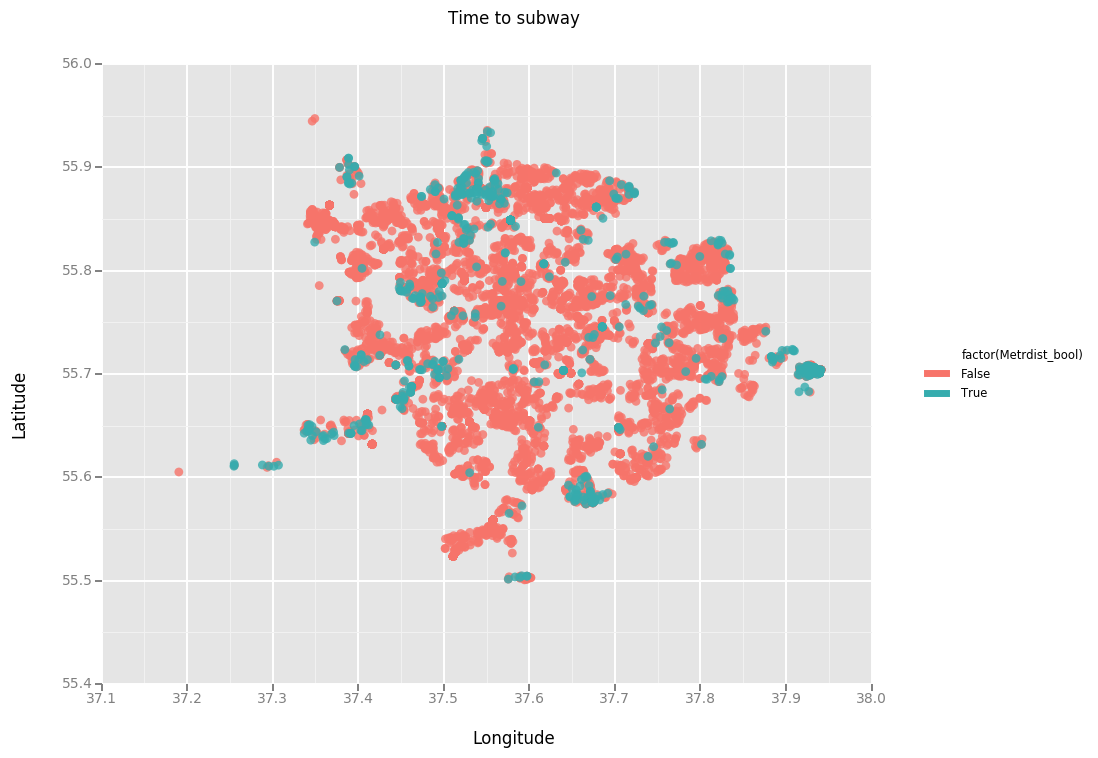

<ggplot: (-9223363263906787391)>

In [25]:
ggplot(aes(x='Dolgota',y='Shirota',color='factor(Metrdist_bool)'),data=data)+\
geom_point(size=40,alpha=0.8)+\
xlab('Longitude')+ylab('Latitude')+ggtitle('Time to subway')

Закономерности никакой не оказалось. Так что сделаем небольшое допущение: будем считать, что время до метро от квартиры такое же как у ближайшей продающейся квартиры с известным этим признаком

In [26]:
kf = KNeighborsClassifier(n_neighbors=1)
kf.fit(data[['Dolgota','Shirota']][data['Metrdist'].notnull()],data['Walk'][data['Metrdist'].notnull()])
data['Walk'][data['Metrdist'].isnull()] = kf.predict(data[['Dolgota','Shirota']][data['Metrdist'].isnull()])
kf.fit(data[['Dolgota','Shirota']][data['Metrdist'].notnull()],data['Metrdist'][data['Metrdist'].notnull()])
data['Metrdist'][data['Metrdist'].isnull()] = kf.predict(data[['Dolgota','Shirota']][data['Metrdist'].isnull()])

/home/stepan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/stepan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Не везде указана высота дома в этажах. Просто заменять на среднее нежелательно, ибо тогда может получиться, что квартира выше чем этажность дома. Так что вычислим во сколько раз обычно дом выше этажа квартиры и умножим на это число

In [27]:
data['Nfloors'][data['Nfloors'].isnull()] = data['Floor'][data['Nfloors'].isnull()]/np.mean(data['Floor']/data['Nfloors'])
del data['Metrdist_bool']
del data['logTotsp']

/home/stepan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Начинаем готовить уже непосредственно анализ. Данные разнородны, поэтому их понадобится нормализовать. Также не помешает подобрать хорошее значение регуляризатора.

In [28]:
ss = StandardScaler()
alpha = np.power(10.0, np.arange(-5, 6, 0.5))

Разобьем нашу выборку на тренировочную и тестовую в отношении 2 к 1. В качестве объясняющей модели возьмем Ридж-регрессию, так как эта модель интерпритируема. Обучим ее при всех выбранных значениях регуляризатора и сохраним полученные значения коэффициентов и среднего абсолютного отклонения на тестовой выборке. Так ожидаются сильные выбросы, то не хочется брать MSE, ибо она сильно наказывает за крупные ошибки

In [29]:
train, test, y_train, y_test = train_test_split(data, y1, test_size=0.33, random_state=42)
db = pd.DataFrame()
train = ss.fit_transform(train)
test = ss.transform(test)
for i in alpha:
    model = Ridge(alpha=i)
    model.fit(train,y_train)
    d = {'alpha':i}
    for j in range(len(data.columns)):
        d.update({data.columns[j]:model.coef_[j]})
    d.update({'score':mae(y_test,model.predict(test))})
    db = db.append(d,ignore_index=True)

Создадим лист различных цветов

In [30]:
from matplotlib import colors
import six
colors_ = list(six.iteritems(colors.cnames))
hex_ = [color[1] for color in colors_]

Посмотрим, как менялось значение целевой метрики на тестовой выборке в зависимости от силы регуляризатора. Лучшее среднее отклонение получилось в районе 3.600.000 рублей

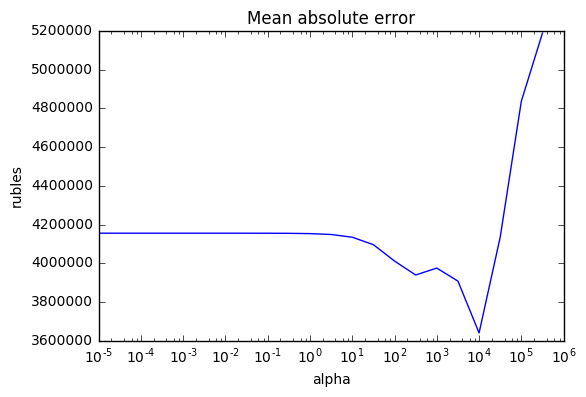

In [31]:
figure()
plot(db['alpha'],db['score'])
xlabel('alpha')
ylabel('rubles')
title('Mean absolute error')
pyplot.xscale('log')

Посмотрим также, как менялись веса признаков. Видно, что общая площадь всегда была самым сильным "положительным" признаком, а расстояния до центра и до метро были сильными "отрицательными" признаками

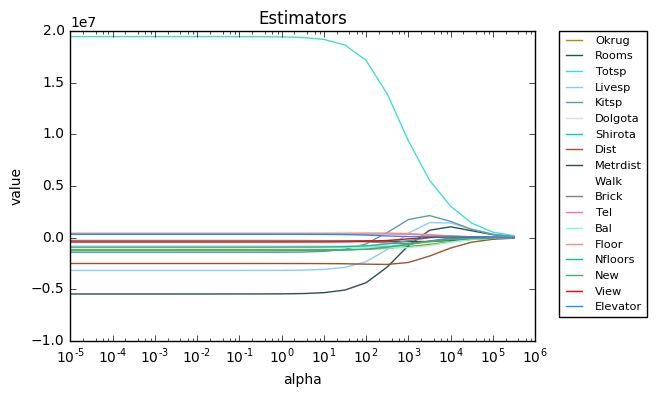

In [32]:
figure()
for i in range(len(data.columns)):
    plot(db['alpha'],db[data.columns[i]],hex_[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=8.2)
xlabel('alpha')
ylabel('value')
title('Estimators')
pyplot.xscale('log')

Попробуем предсказывать не цену, а логарифм цены. Как мы ранее заметили, для этого хорош признак логорифма оющей площади

In [33]:
data['Totsp']=np.log(data['Totsp'])
train, test, y_train, y_test = train_test_split(data, y2, test_size=0.33, random_state=42)
db = pd.DataFrame()
train = ss.fit_transform(train)
test = ss.transform(test)
for i in alpha:
    model = Ridge(alpha=i)
    model.fit(train,y_train)
    d = {'alpha':i}
    for j in range(len(data.columns)):
        d.update({data.columns[j]:model.coef_[j]})
    d.update({'score':mae(10**y_test,10**model.predict(test))})
    db = db.append(d,ignore_index=True)

Итак, наша средняя ошибка упала до 2.500.000 рублей, почти на треть. Да и результаты модели стали менее чувствительны к регуляризатору

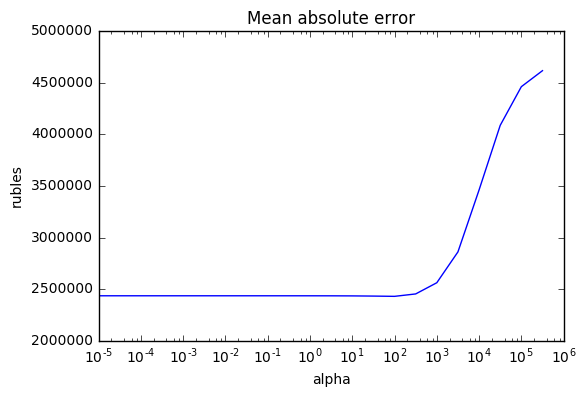

In [34]:
figure()
plot(db['alpha'],db['score'])
xlabel('alpha')
ylabel('rubles')
title('Mean absolute error')
pyplot.xscale('log')

И вновь большая площадь - это "хорошо", а большое расстояние до центра - "плохо"

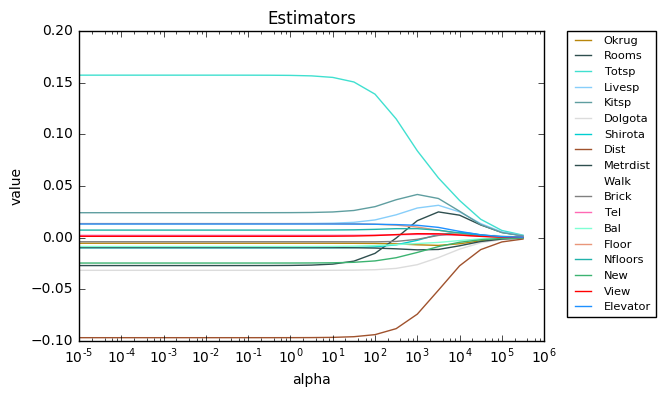

In [35]:
figure()
for i in range(len(data.columns)):
    plot(db['alpha'],db[data.columns[i]],hex_[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=8.2)
xlabel('alpha')
ylabel('value')
title('Estimators')
pyplot.xscale('log')

Посмотрим, может у нас какие признаки сильно коррелируют. Но вроде нет

In [36]:
kor = []
for i in range(len(data.columns)):
    for j in range(i+1,len(data.columns)):
        if pearsonr(data[data.columns[i]],data[data.columns[j]])[0]>0.5:
            kor.append([data.columns[i],data.columns[j],pearsonr(data[data.columns[i]],data[data.columns[j]])])
kor

[['Rooms', 'Totsp', (0.79073422266764681, 0.0)],
 ['Rooms', 'Livesp', (0.71117601950292852, 0.0)],
 ['Totsp', 'Livesp', (0.73720402784628858, 0.0)],
 ['Totsp', 'Kitsp', (0.56759234843532191, 0.0)],
 ['Floor', 'Nfloors', (0.62447356043385172, 0.0)]]

Признаки округа и вида из окна на самом деле категориальные. Поэтому стоит их разбить в дамми-переменные

In [37]:
data = pd.get_dummies(data,prefix=['Okrug','View'],columns=['Okrug','View'],drop_first=True)

Так же добавим вариацию дамми-переменных, объясняющую на сколько меняется стоимость квадратного метра в зависимости от наличия лифта, балкона, округа и т.д.

In [38]:
for i in data.columns:
    if len(data[i].unique())==2:
        data[str(i)+'_'+'space'] = data['Totsp']*data[i]

И наконец, обучим на новых признаках модель

In [39]:
train, test, y_train, y_test = train_test_split(data, y2, test_size=0.33, random_state=42)
db = pd.DataFrame()
train = ss.fit_transform(train)
test = ss.transform(test)
for i in alpha:
    model = Ridge(alpha=i)
    model.fit(train,y_train)
    d = {'alpha':i}
    for j in range(len(data.columns)):
        d.update({data.columns[j]:model.coef_[j]})
    d.update({'score':mae(10**y_test,10**model.predict(test))})
    db = db.append(d,ignore_index=True)

Результаты определенно улучшлись, не потеряв стабильности

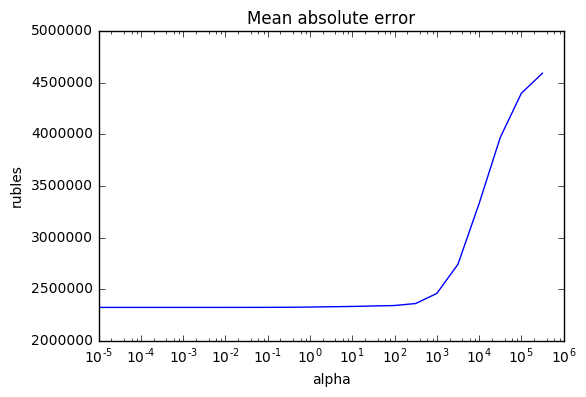

In [40]:
figure()
plot(db['alpha'],db['score'])
xlabel('alpha')
ylabel('rubles')
title('Mean absolute error')
pyplot.xscale('log')

Как всегда веса общей площади и расстояния до метро держатся до последнего

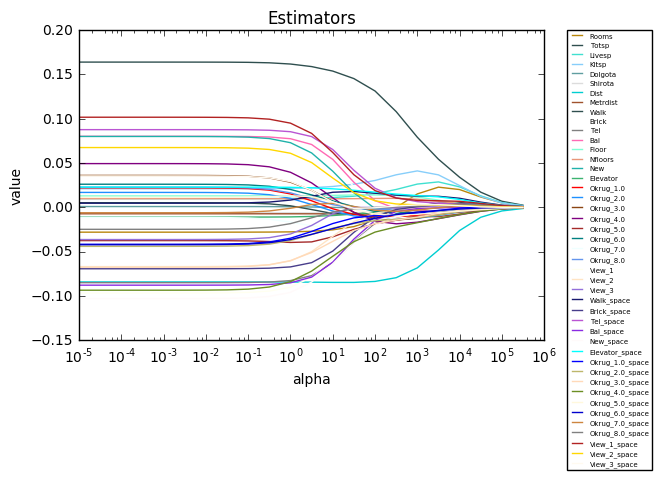

In [41]:
figure()
for i in range(len(data.columns)):
    plot(db['alpha'],db[data.columns[i]],hex_[i])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=5)
xlabel('alpha')
ylabel('value')
title('Estimators')
pyplot.xscale('log')

Уберем произведения признаков, полученные на прошлом шаге

In [42]:
for i in data.columns[27:]:
    del data[i]

И снова добавим, но уже все попарные произведения

In [43]:
k = len(data.columns)
for i in range(k):
    for j in range(i+1,k):
        data[data.columns[i]+'_'+data.columns[j]] = data[data.columns[i]]*data[data.columns[j]]

Посмотрим, что из этого получится

In [44]:
train, test, y_train, y_test = train_test_split(data, y2, test_size=0.33, random_state=42)
db = pd.DataFrame()
train = ss.fit_transform(train)
test = ss.transform(test)
for i in alpha:
    model = Ridge(alpha=i)
    model.fit(train,y_train)
    d = {'alpha':i}
    for j in range(len(data.columns)):
        d.update({data.columns[j]:model.coef_[j]})
    d.update({'score':mae(10**y_test,10**model.predict(test))})
    db = db.append(d,ignore_index=True)

Алгоритм стал менее стабильным, но зато снова улучшил результат

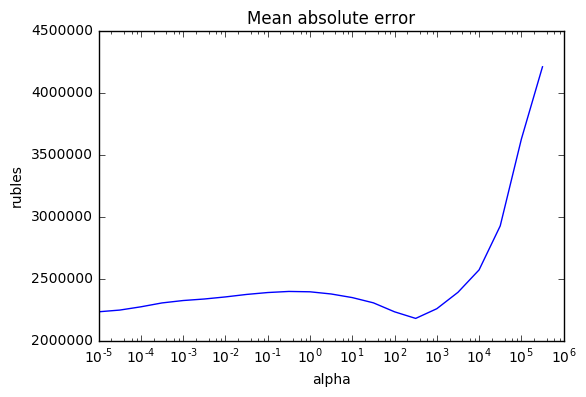

In [45]:
figure()
plot(db['alpha'],db['score'])
xlabel('alpha')
ylabel('rubles')
title('Mean absolute error')
pyplot.xscale('log')

Посмотрим, как меняли веса самых интересных признаков. Как видно, общая площадь до последнего вносила "положительный" вклад в цену квартиры, а расстояние до метро - "отрицательный". Алгоритм распознал, что новый дом лучше вторички, но в конце признал этот признак не очень существенным. То же и с расстоянием до метро в минутах, если идти пешком. Чем больше - тем хуже, но в пределе: менее существенно, чем другие прзнаки. Интересно ведет себя вес признака количества комнат. Признак коррелирует с признаком общей площади, поэтому алгоритм то невилирует вклад площади этим признаком, то дополняет

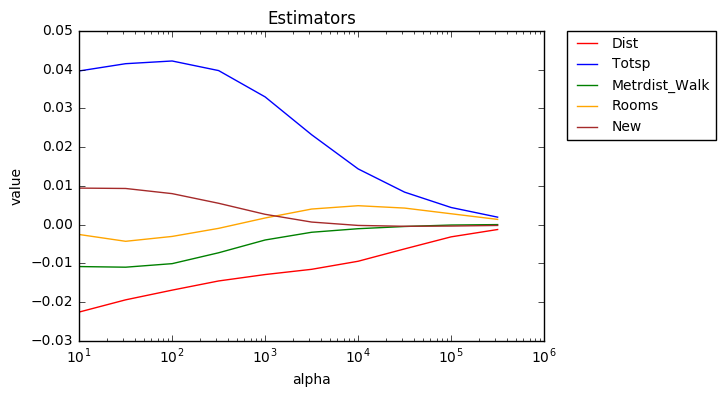

In [46]:
figure()
plot(db['alpha'][12:],db['Dist'][12:],'r')
plot(db['alpha'][12:],db['Totsp'][12:],'b')
plot(db['alpha'][12:],db['Metrdist_Walk'][12:],'g')
plot(db['alpha'][12:],db['Rooms'][12:],'orange')
plot(db['alpha'][12:],db['New'][12:],'brown')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=10)
xlabel('alpha')
ylabel('value')
title('Estimators')
pyplot.xscale('log')

Выпишем веса вообще всех признаков при лучшем значении регуляризатора

In [47]:
coefs = pd.DataFrame()
for i in db.columns[:-2]:
    coefs = coefs.append({'Feat':i,'Val':db[i][argmin(db['score'])]},ignore_index=True)

Посмотрим на самые "отрицательные"

In [48]:
coefs.sort_values('Val').reset_index(drop=True).head()

,Feat,Val
0,Kitsp_Dist,-0.015608
1,Dist_New,-0.015547
2,Rooms_Bal,-0.015060
3,Shirota_Dist,-0.014550
4,Dist,-0.014522


И на самые "положительные"

In [49]:
coefs.sort_values('Val').reset_index(drop=True).tail()

,Feat,Val
373,Bal_View_3,0.012146
374,Totsp_Kitsp,0.020933
375,Totsp_Dolgota,0.039469
376,Totsp_Shirota,0.039744
377,Totsp,0.039768


Наконец, посмотрим точное лучшее значение метрики на тестовой выборке

In [50]:
min(db['score'])

2181654.5598541927

Давайте также для сравнения обучим плохо интерпритируемый, но сильный алгоритм: бустинг

In [51]:
params = {
    'min_child_weight': 7,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 5,
    'subsample': 0.8,
    'silent': 1,
}
xgtrain = xgb.DMatrix(train, label=y_train)
xgtest = xgb.DMatrix(test, label=y_test)
watchlist = [(xgtrain, 'train'), (xgtest, 'eval')]

In [52]:
model = xgb.train(params, xgtrain, 100000, watchlist, early_stopping_rounds=50,verbose_eval=100)

[0]	train-rmse:5.76865	eval-rmse:5.77535
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.048093	eval-rmse:0.066953
[200]	train-rmse:0.037494	eval-rmse:0.063891
[300]	train-rmse:0.029665	eval-rmse:0.062805
[400]	train-rmse:0.024358	eval-rmse:0.062207
[500]	train-rmse:0.020199	eval-rmse:0.062004
[600]	train-rmse:0.01701	eval-rmse:0.061813
Stopping. Best iteration:
[617]	train-rmse:0.016465	eval-rmse:0.061768



Посмотрим на его результат и в очередной раз осознаем, что можно быть очень умным, уметь проверять разные гипотезы о признаках и модели. А можно сделать одну большую кнопочку на клаиватуре: "XGB". И быть классным

In [53]:
mae(10**y_test,10**model.predict(xgtest))

1677551.1093617918

Снова обучим наш бустинг, но уже на всей выборке

In [54]:
xgall = xgb.DMatrix(data,label = y2)
model = xgb.train(params, xgall, 617, verbose_eval=False)

Сохраним веса признаков в бустинге

In [55]:
wght = model.get_score()
w = pd.DataFrame(columns=['feature','weight'])
for i in wght:
    w = w.append({'feature':i,'weight':wght[i]},ignore_index=True)

Посмотрим на самые сильные признаки

In [56]:
w.sort_values('weight',ascending=False).head()

,feature,weight
117,Dolgota_Shirota,238.0
64,Kitsp_Dist,201.0
73,Shirota,196.0
93,Livesp_Dist,195.0
163,Dist_Nfloors,184.0


И на самые слабые

In [57]:
w.sort_values('weight',ascending=False).tail()

,feature,weight
110,Elevator_Okrug_8.0,1.0
109,New_Elevator,1.0
38,Okrug_5.0,1.0
150,New_View_3,1.0
14,Brick,1.0


Отсортируем по силе признака

In [58]:
w = w.sort_values('weight',ascending=False).reset_index(drop=True)

И пронумеруем в порядке убывания силы

In [59]:
w['feature'] = pd.factorize(w['feature'].values)[0]

Посмотри на распределение сил

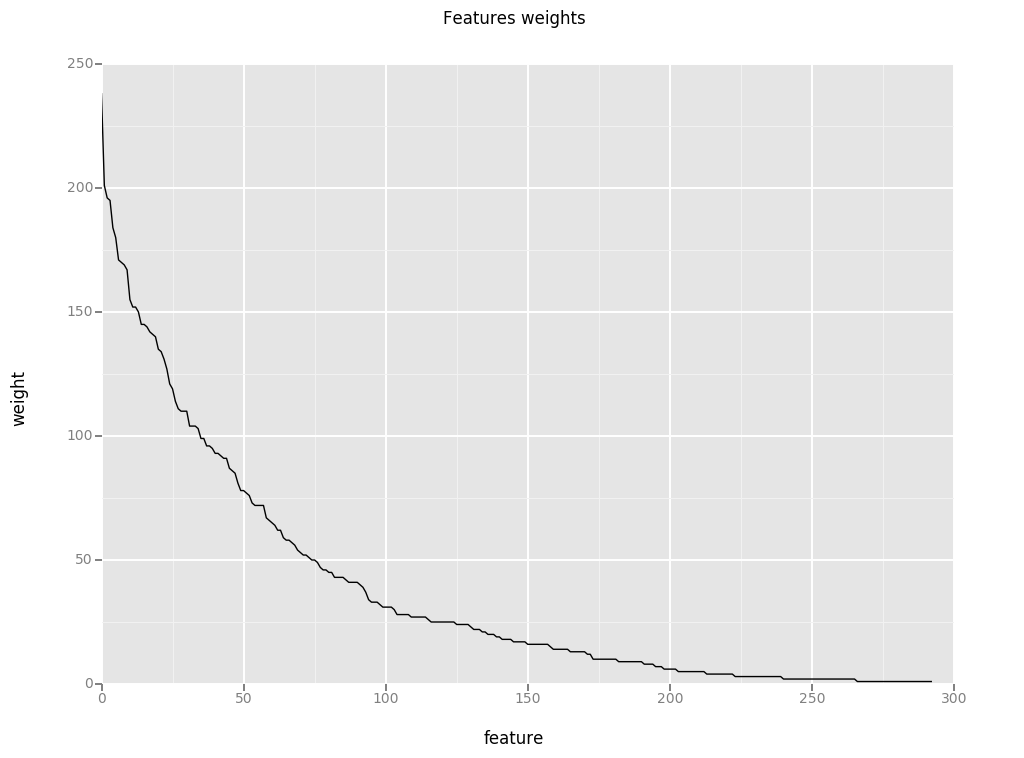

<ggplot: (-9223363263907482799)>

In [60]:
ggplot(aes(x='feature',y='weight'),data=w)+geom_line()+labs(title='Features weights')

Откроем нашу оригинальную выборку и добавим к ней столбец, хранящий разницу между предсказанной ценой и настоящей

In [61]:
data2 = pd.read_csv('cian.csv')
data2 = data2[np.log10(data2['Price'])>6]
data2['difference'] = 10**model.predict(xgall)-data2['Price']
data2 = data2.sort_values('difference').reset_index(drop=True)

Посмотрим на самые переоцененные (с точки зрения нашего алгоритма) квартиры

In [62]:
data2[data2.columns[1:]].head()

,Okrug,Rooms,Price,Totsp,Livesp,Kitsp,Dolgota,Shirota,Dist,Metrdist,Walk,Brick,Tel,Bal,Floor,Nfloors,New,View,Elevator,difference
0,0.0,3.0,76483680.0,95.0,65.0,NaN,37.572899,55.721731,4.612590,10.0,1.0,0.0,1.0,0.0,3.0,5.0,0.0,улица,1.0,-17384800.0
1,0.0,3.0,177060000.0,136.2,NaN,NaN,37.598043,55.742772,1.826434,7.0,1.0,0.0,0.0,0.0,3.0,6.0,1.0,двор и улица,1.0,-14514240.0
2,0.0,4.0,178580376.0,151.0,NaN,NaN,37.601609,55.774867,2.613663,6.0,1.0,0.0,1.0,0.0,5.0,10.0,0.0,двор,1.0,-12206344.0
3,0.0,4.0,234530831.0,237.4,NaN,NaN,37.599678,55.736458,2.295329,15.0,1.0,0.0,0.0,0.0,2.0,8.0,0.0,двор и улица,1.0,-9261967.0
4,1.0,4.0,89284680.0,144.2,86.1,NaN,37.567042,55.788029,5.044660,7.0,1.0,1.0,0.0,0.0,5.0,10.0,0.0,двор,1.0,-8266016.0


И на самые неодоцененные

In [63]:
data2[data2.columns[1:]].tail()

,Okrug,Rooms,Price,Totsp,Livesp,Kitsp,Dolgota,Shirota,Dist,Metrdist,Walk,Brick,Tel,Bal,Floor,Nfloors,New,View,Elevator,difference
7162,0.0,3.0,98510980.0,224.0,170.0,10.0,37.539078,55.747115,5.105801,2.0,1.0,1.0,1.0,0.0,42.0,73.0,0.0,двор и улица,1.0,4537484.0
7163,0.0,4.0,102615604.0,179.0,NaN,NaN,37.585449,55.734709,3.015305,7.0,1.0,0.0,1.0,0.0,3.0,7.0,0.0,двор и улица,0.0,4682956.0
7164,0.0,4.0,75846316.0,152.0,NaN,NaN,37.561392,55.759932,3.720063,7.0,1.0,0.0,1.0,0.0,4.0,12.0,0.0,двор и улица,1.0,4950708.0
7165,0.0,3.0,76000000.0,156.0,93.0,23.0,37.593183,55.749486,1.731471,8.0,1.0,0.0,0.0,0.0,5.0,7.0,0.0,двор,1.0,7010168.0
7166,0.0,5.0,445517436.0,368.0,300.0,25.0,37.616252,55.735915,1.991129,3.0,1.0,1.0,1.0,1.0,6.0,9.0,0.0,двор и улица,1.0,9657476.0


Спасибо за внимание!